## 1. Load and Preprocess the Data

In [1]:
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
from dataloader import *
from pca import *
from matplotlib import pyplot as plt

# 1.b) Show six different images 
images, labels = load_data(data_dir="./CAFE/") 
for i in range(0,6):
    display_face(images[i])

# 1.c) A figure showing 6 eigenvectors
pca = PCA(k=50)
pca.fit(np.array(images[:]))
pca.display()

Total number of images: 80 and labels: 80
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Converting from array to PIL Image
Save PCA image to ./pca_display.png


## 2. Logistic Regression

### 2(a) Implment Logistic Regression via Gradient Descent

In [2]:
# Split the subjects into training, testing and holdout subject numbers
def split_subjects(subjects):
    train = []
    test = []
    holdout = []
    
    #Get total number of subjects to be splitted
    total_subjects = len(subjects)
    
    while len(subjects) > total_subjects * 0.2:
        cur = np.random.choice(subjects)
        subjects.remove(cur)
        #Randomly choose the subjects to be test set
        if len(train) < total_subjects * 0.6:
            train.append(cur)
        #Then randomly choose for test set
        else:
            test.append(cur)
            
    holdout = subjects.copy()
    
    return train, test, holdout

In [3]:
# Return the subjects names with indicated subjects numbers and emotions
def emotion_list(pics, subjects_num, emotions):
    
    all_subj = []
    all_emotions = []
    
    #Special condition for 'h' which stands for happy
    for i in emotions:
        if i == 'h':
            all_emotions += [x for x in pics if (i in x[:-3]) and ('ht' not in x[:-3])]
        else:
            all_emotions += [x for x in pics if i in x[:-3]]
    
    for i in subjects_num:
        cur_subj = [x for x in all_emotions if i in x[:-3]]
        all_subj += cur_subj
        
    return all_subj

In [4]:
# Return label/labels of the indicated subject name:
def get_label(label0, subject_name):
    if label0 in subject_name[:-3]:
        return 0
    return 1

def get_labels(label0, subject_names):
    return [[get_label(label0, x)] for x in subject_names]

In [5]:
# Return the image/images of the indicated subject name
def get_image(subject_name):
    return images[labels.index(subject_name)]

def get_image_list(subject_names):
    return [get_image(x) for x in subject_names]

In [6]:
#Split train, test, and holdout sets
def train_test_holdout_split(labels, emotions):
    
    #Get the total number of different subjects and split to identified sets according to their subject numbers
    subjects = np.unique([x[:3] for x in labels]).tolist()
    train, test, holdout = split_subjects(subjects)

    #Get the list of subjects with identified emotions
    train = emotion_list(labels, train, emotions)
    test = emotion_list(labels, test, emotions)
    holdout = emotion_list(labels, holdout, emotions)

    #Get the images and the labels for identitied subjects
    train_X = get_image_list(train)
    train_Y = get_labels(emotions[1], train)
    test_X = get_image_list(test)
    test_Y = get_labels(emotions[1], test)
    holdout_X = get_image_list(holdout)
    holdout_Y = get_labels(emotions[1], holdout)
    
    return train_X, train_Y, test_X, test_Y, holdout_X, holdout_Y

In [7]:
#Implementation of logistic regression via gradient descent

#Sigmoid function
def sigmoid(x):
    return 1/(1 + np.exp(-x))

#Prediction with features and weights
def predict(X, w):
    return sigmoid(np.dot(X, w))

#Decide which class the given probability would be
def decide(prob):
    if prob >= 0.5:
        return 1
    return 0 

#Update the weights with given dataset and learning rate
def log_reg(X, Y, w, lr):
    num_feat = len([0])
    pred = predict(X, w)
    grad = np.dot(np.asarray(X).T, pred - Y) * lr / num_feat
    return w - grad

#The loss fumction
def loss_func(X, Y, w):

    feat_num = len(X)
    pred = predict(X, w)
    
    #loss when label is 1 or 0
    label1_cost = Y * np.log(pred)
    label0_cost = [[1 - x[0]] for x in Y] * np.log(1 - pred)
    
    #Sum up the cost
    total_cost = label1_cost + label0_cost
    
    return np.average(-total_cost)

#Transform the images with fitted PCA
def pca_transform_cur(pca, X):
    transformed_X = []
    for i in range(len(X)):
        transformed_X += pca.transform(np.array(X[i])).tolist()
    return transformed_X
        

#Train the dataset with given training set and return weights and costs for training and holdout sets
def train(train_X, train_Y, holdout_X, holdout_Y, lr, epochs):
    
    costs_t = []
    costs_h = []
    weights = []
    
    #initialize weights
    w = [[0] for x in range(len(train_X[0]))]

    #Update Losses and weights for each epoch
    for i in range(epochs):
        
        w = log_reg(train_X, train_Y, w, lr)

        cost_t = loss_func(train_X, train_Y, w)
        cost_h = loss_func(holdout_X, holdout_Y, w)
        
        costs_t.append(cost_t)
        costs_h.append(cost_h)
        weights.append(w)

    return weights, costs_t, costs_h

### 2(b) Evaluate on Happy vs Maudlin

In [8]:
# Set up training, testing and holdout sets
all_k = [1, 2, 4, 8]
needed_epoches_in_index = [1, 3, 7, 9]

test_errors = []
holdout_errors = []
allrun_kaccuracy = []

#For each run
for i in range(5):
    #Split the dataset into train, test, and holdout
    train_X, train_Y, test_X, test_Y, holdout_X, holdout_Y = train_test_holdout_split(labels, ['h', 'm'])
    
    #Inicialize all acuracies, test errors and holdout errors
    allk_epoches_test_errors = []
    allk_epoches_holdout_errors = []
    allk_accuracy = []
    
    #For different value of principal components
    for j in all_k:
        #Initialize for each principal componenets all the epoches errors
        curk_epoches_test_errors = []
        curk_epoches_holdout_errors = []
    
        #Set up PCA to fit current training set
        cur_pca = PCA(k=j)
        cur_pca.fit(np.array(train_X))
        
        #Transform dataset features with indicated PCA
        cur_train_X = pca_transform_cur(cur_pca, train_X)
        cur_test_X = pca_transform_cur(cur_pca, test_X)
        cur_holdout_X = pca_transform_cur(cur_pca, holdout_X)
        
        #Train the dataset for current amount of principal componenets
        weights, costs_t, costs_h = train(cur_train_X, train_Y, cur_holdout_X, holdout_Y, 0.2, 10)
        
        #Get the minimum holdout error with its corresponding weight
        min_holdout_error = min(costs_h)
        min_holdout_error_index = costs_h.index(min_holdout_error)
        min_holdout_w = weights[min_holdout_error_index]

        #Predict with the above weights and get accuracies
        predictions = predict(cur_test_X, min_holdout_w)
        predictions = [[decide(x[0])] for x in predictions]
        diff = np.array(predictions).flatten() - np.array(test_Y).flatten()
        test_accuracy = np.average([1 if x == 0 else 0 for x in diff])
        allk_accuracy.append(test_accuracy)
        
        #Get the indicated epochs' errors
        for k in needed_epoches_in_index:
            curk_epoches_test_errors.append(costs_t[k])
            curk_epoches_holdout_errors.append(costs_h[k])
        
        allk_epoches_test_errors.append(curk_epoches_test_errors)
        allk_epoches_holdout_errors.append(curk_epoches_holdout_errors)
    
    #Append the values for current amount of principal components
    allrun_kaccuracy.append(allk_accuracy)
    test_errors.append(allk_epoches_test_errors)
    holdout_errors.append(allk_epoches_holdout_errors)

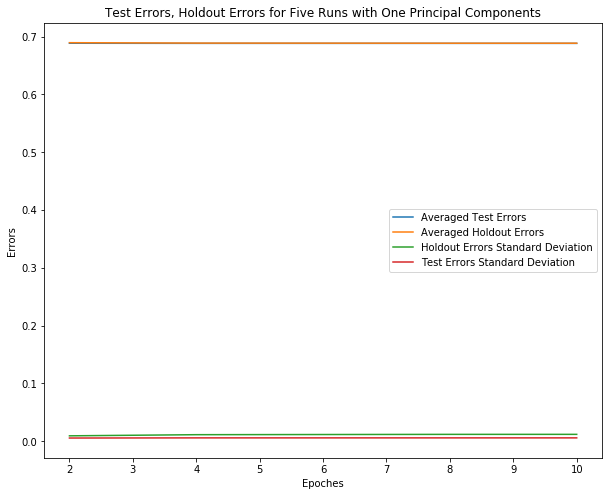

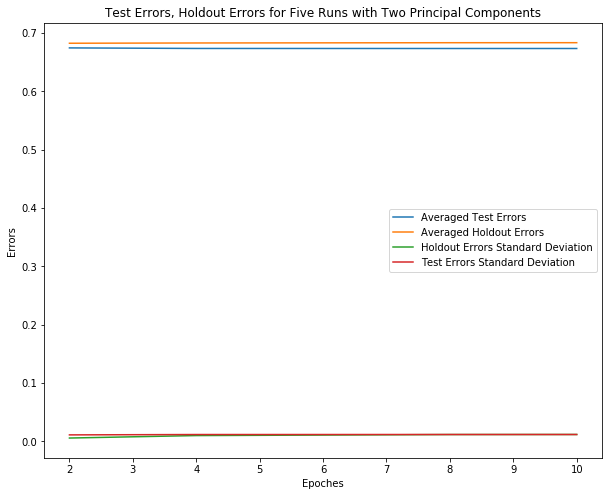

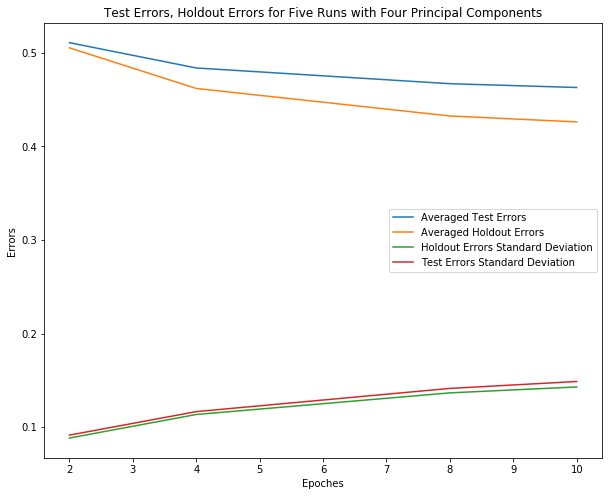

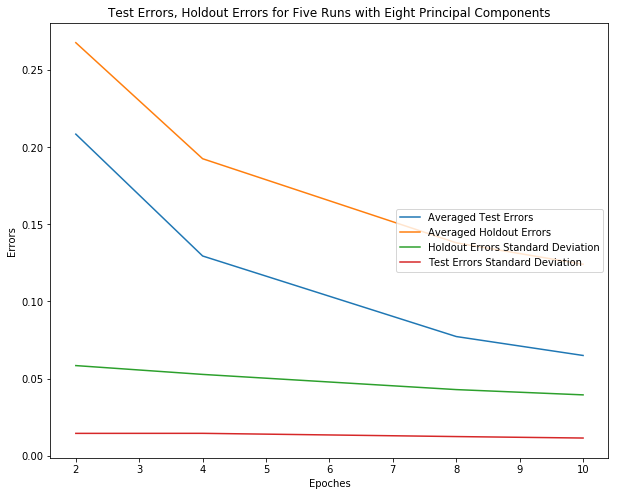

In [9]:
#Plotting Plots for different amount of principal values
import matplotlib.pyplot as plt

num_epoches_required = [2, 4, 8, 10]
num_k_strings = ['One', 'Two', 'Four', 'Eight']

#Revise the order of the errors
for k in range(4):
    total_test_errors = []
    total_holdout_errors = []
    for i in range(4):
        cur_test_errors = []
        cur_holdout_errors = []
        for j in range(5):
            cur_test_errors.append(test_errors[j][k][i]) 
            cur_holdout_errors.append(holdout_errors[j][k][i])
        total_test_errors.append(cur_test_errors)
        total_holdout_errors.append(cur_holdout_errors)

    #Get average and std of test and holdout errors
    averaged_test_errors = [np.average(x) for x in total_test_errors]
    averaged_holdout_errors = [np.average(x) for x in total_holdout_errors]

    std_test_errors = [np.std(x) for x in total_test_errors]
    std_holdout_errors = [np.std(x) for x in total_holdout_errors]

    #Graph and save to current amount of principal componenets
    graph_title = 'Test Errors, Holdout Errors for Five Runs with ' + num_k_strings[k] + ' Principal Components'
    fname = num_k_strings[k] + '_princ_comp.png'
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot()
    ax.plot(num_epoches_required, averaged_test_errors, label='Averaged Test Errors')
    ax.plot(num_epoches_required, averaged_holdout_errors, label='Averaged Holdout Errors')
    ax.plot(num_epoches_required, std_holdout_errors, label='Holdout Errors Standard Deviation')
    ax.plot(num_epoches_required, std_test_errors, label='Test Errors Standard Deviation')
    ax.set(xlabel='Epoches', ylabel = 'Errors',
           title = graph_title)
    leg = ax.legend(loc = 7)
    fig.savefig(fname)

In [10]:
#Get the accuracy for different amount of principal values

#Revise the orders of the accuracies so that each list correpond to their amount of principal values
for i in range(len(allrun_kaccuracy[0])):
    cur_k_accu = []
    for j in range(len(allrun_kaccuracy)):
        cur_k_accu.append(allrun_kaccuracy[j][i])
        cur_k_mean_accu = np.average(cur_k_accu)
        cur_k_std_accu = np.std(cur_k_accu)
    #Print out the values
    print('The Test Accuracy for ' + num_k_strings[i] + ' Principal Components is ' 
          + str(cur_k_mean_accu) + '(' + str(cur_k_std_accu) + ').')

The Test Accuracy for One Principal Components is 0.6(0.25495097567963926).
The Test Accuracy for Two Principal Components is 0.7(0.09999999999999999).
The Test Accuracy for Four Principal Components is 1.0(0.0).
The Test Accuracy for Eight Principal Components is 1.0(0.0).


In [11]:
#Eight Principle Components
needed_epoches_in_index = [1, 3, 7, 9]

learning_rates = [0.0001, 0.2, 0.99]
test_errors = []
holdout_errors = []
allrun_accuracy = []

#Five Runs for best number of principal components
for i in range(5):
    
    #Split training, testing and holdout sets
    train_X, train_Y, test_X, test_Y, holdout_X, holdout_Y = train_test_holdout_split(labels, ['h', 'm'])
    
    #Initialize test errors and accuracies for all epoches for current run
    all_epoches_test_errors = []
    all_epoches_holdout_errors = []
    all_accuracy = []
    
    #PCA to current training dataset
    cur_pca = PCA(k = 8)
    cur_pca.fit(np.array(train_X))
    
    #Transform training, testing and holdout set to current PCA
    cur_train_X = pca_transform_cur(cur_pca, train_X)
    cur_test_X = pca_transform_cur(cur_pca, test_X)
    cur_holdout_X = pca_transform_cur(cur_pca, holdout_X)
        
    
    #Run for each learning rate
    for r in learning_rates:
        cur_epoches_test_errors = []
        cur_epoches_holdout_errors = []
    
        #Get training losses, holdout losses for current learning rate
        weights, costs_t, costs_h = train(cur_train_X, train_Y, cur_holdout_X, holdout_Y, r, 10)
        
        #Get the minimum holdout rate with its corresponding weights
        min_holdout_error = min(costs_h)
        min_holdout_error_index = costs_h.index(min_holdout_error)
        min_holdout_w = weights[min_holdout_error_index]

        #Calculate the test accuracy for the minimum holdout error rate with its weights
        predictions = predict(cur_test_X, min_holdout_w)
        predictions = [[decide(x[0])] for x in predictions]
        diff = np.array(predictions).flatten() - np.array(test_Y).flatten()
        test_accuracy = np.average([1 if x == 0 else 0 for x in diff])
        all_accuracy.append(test_accuracy)
        
        #Get the test errors and holdout errors for every the required epoches
        for k in needed_epoches_in_index:
            cur_epoches_test_errors.append(costs_t[k])
            cur_epoches_holdout_errors.append(costs_h[k])
        
        all_epoches_test_errors.append(cur_epoches_test_errors)
        all_epoches_holdout_errors.append(cur_epoches_holdout_errors)
    
    allrun_accuracy.append(all_accuracy)
    test_errors.append(all_epoches_test_errors)
    holdout_errors.append(all_epoches_holdout_errors)

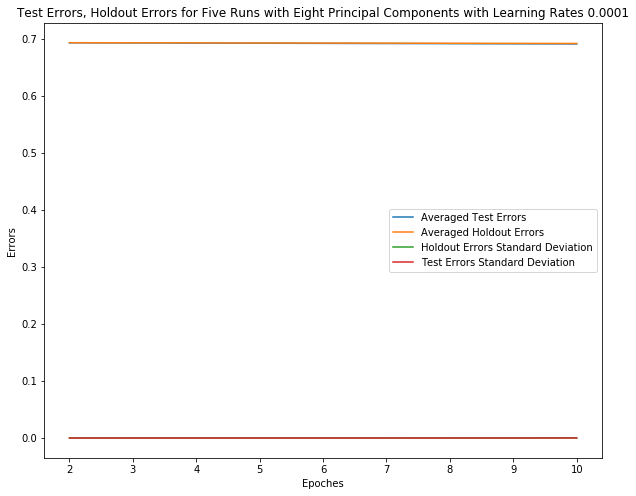

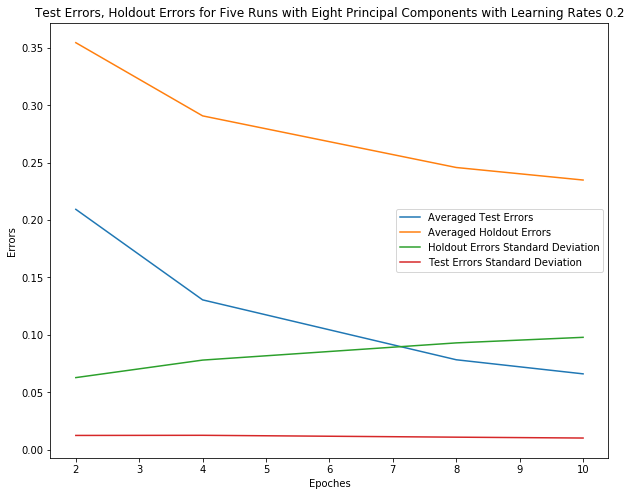

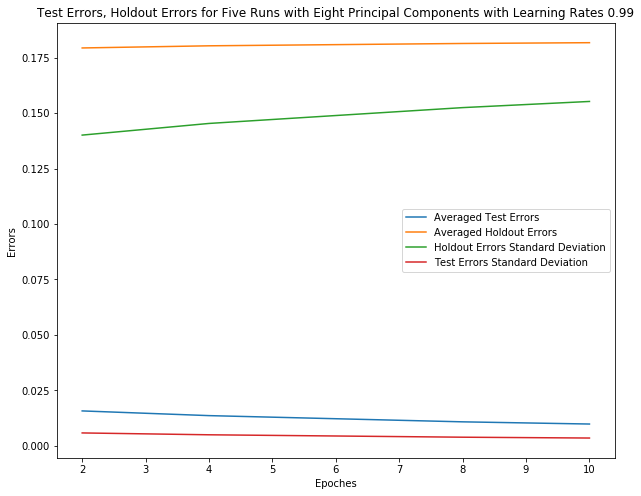

In [12]:
#Plot the test accuracy with different learning rates
import matplotlib.pyplot as plt

num_epoches_required = [2, 4, 8, 10]

#Revise the order of the errors
for k in range(3):
    total_test_errors = []
    total_holdout_errors = []
    
    for i in range(4):
        cur_test_errors = []
        cur_holdout_errors = []
        
        for j in range(5):
            cur_test_errors.append(test_errors[j][k][i]) 
            cur_holdout_errors.append(holdout_errors[j][k][i])
        total_test_errors.append(cur_test_errors)
        total_holdout_errors.append(cur_holdout_errors)

    #Get average and std for test and holdout errors
    averaged_test_errors = [np.average(x) for x in total_test_errors]
    averaged_holdout_errors = [np.average(x) for x in total_holdout_errors]

    std_test_errors = [np.std(x) for x in total_test_errors]
    std_holdout_errors = [np.std(x) for x in total_holdout_errors]

    #Plot each graph and save to files
    graph_title = 'Test Errors, Holdout Errors for Five Runs with Eight Principal Components with Learning Rates ' + str(learning_rates[k])
    fname = str(learning_rates[k]) + '_learning_rates.png'
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot()
    ax.plot(num_epoches_required, averaged_test_errors, label='Averaged Test Errors')
    ax.plot(num_epoches_required, averaged_holdout_errors, label='Averaged Holdout Errors')
    ax.plot(num_epoches_required, std_holdout_errors, label='Holdout Errors Standard Deviation')
    ax.plot(num_epoches_required, std_test_errors, label='Test Errors Standard Deviation')
    ax.set(xlabel='Epoches', ylabel = 'Errors',
           title = graph_title)
    leg = ax.legend(loc = 7)
    fig.savefig(fname)

In [13]:
#Print out the accuracies with different amount of learning rate
all_lr_accu = []
all_lr_test_err = []
all_lr_holdout_err = []

#Revise the orders
for i in range(len(learning_rates)):
    cur_lr_accu = []
    
    for j in range(5):
        cur_lr_accu.append(allrun_accuracy[j][i])
        
    all_lr_accu.append(cur_lr_accu)
    cur_mean_accu = np.average(cur_lr_accu)
    cur_std_accu = np.std(cur_lr_accu)
    print('The Test Accuracy for Eight Principal Components with Learning Rate ' + str(learning_rates[i]) + ' is ' 
          + str(cur_mean_accu) + '(' + str(cur_std_accu) + ').')

The Test Accuracy for Eight Principal Components with Learning Rate 0.0001 is 0.95(0.09999999999999999).
The Test Accuracy for Eight Principal Components with Learning Rate 0.2 is 0.95(0.09999999999999999).
The Test Accuracy for Eight Principal Components with Learning Rate 0.99 is 0.95(0.09999999999999999).


### 2(c) Evaluate on Afraid vs. Surprised

In [14]:
# Set up training, testing and holdout sets
needed_epoches_in_index = [1, 3, 7, 9]

test_errors = []
holdout_errors = []
all_accuracy = []

for i in range(5):
    #Filter out fear and surprised train, test and holdout set
    train_X, train_Y, test_X, test_Y, holdout_X, holdout_Y = train_test_holdout_split(labels, ['f', 's'])
    
    #Initialize errors
    all_epoches_test_errors = []
    all_epoches_holdout_errors = []

    cur_epoches_test_errors = []
    cur_epoches_holdout_errors = []
    
    #Fit and transform with indicated PCA
    cur_pca = PCA(k=8)
    cur_pca.fit(np.array(train_X))
        
    cur_train_X = pca_transform_cur(cur_pca, train_X)
    cur_test_X = pca_transform_cur(cur_pca, test_X)
    cur_holdout_X = pca_transform_cur(cur_pca, holdout_X)
    
    #Train with the train sets
    weights, costs_t, costs_h = train(cur_train_X, train_Y, cur_holdout_X, holdout_Y, 0.2, 10)
        
    #Predict with the weights which gives minimum holdout errors
    min_holdout_error = min(costs_h)
    min_holdout_error_index = costs_h.index(min_holdout_error)
    min_holdout_w = weights[min_holdout_error_index]

    predictions = predict(cur_test_X, min_holdout_w)
    predictions = [[decide(x[0])] for x in predictions]

    #Get accuracies
    diff = np.array(predictions).flatten() - np.array(test_Y).flatten()
    test_accuracy = np.average([1 if x == 0 else 0 for x in diff])
    all_accuracy.append(test_accuracy)
        
    #Append the accuracies to the list
    for k in needed_epoches_in_index:
        cur_epoches_test_errors.append(costs_t[k])
        cur_epoches_holdout_errors.append(costs_h[k])
        
    test_errors.append(cur_epoches_test_errors)
    holdout_errors.append(cur_epoches_holdout_errors)

In [15]:
#Print the accuracy
print('The Test Accuracy for Eight Principal Components is ' 
          + str(np.average(all_accuracy)) + '(' + str(np.std(all_accuracy)) + ').')

The Test Accuracy for Eight Principal Components is 0.6(0.1224744871391589).


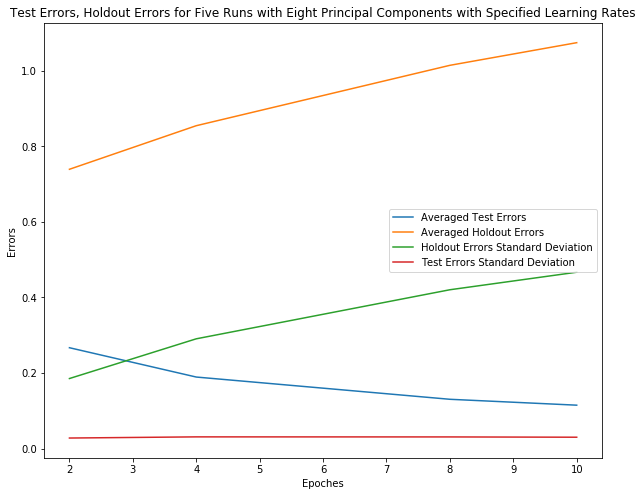

In [16]:
total_test_errors = []
total_holdout_errors = []

#Revise the orders
for i in range(4):
    cur_test_errors = []
    cur_holdout_errors = []
        
    for j in range(5):
        cur_test_errors.append(test_errors[j][i]) 
        cur_holdout_errors.append(holdout_errors[j][i])

    total_test_errors.append(cur_test_errors)
    total_holdout_errors.append(cur_holdout_errors)
    
#Get average and std for errors
averaged_test_errors = [np.average(x) for x in total_test_errors]
averaged_holdout_errors = [np.average(x) for x in total_holdout_errors]

std_test_errors = [np.std(x) for x in total_test_errors]
std_holdout_errors = [np.std(x) for x in total_holdout_errors]

graph_title = 'Test Errors, Holdout Errors for Five Runs with Eight Principal Components with Specified Learning Rates'
fname = '2c_plot.png'

#Plot and save the plots    
fig = plt.figure(figsize=(10,8))
ax = plt.subplot()
ax.plot(num_epoches_required, averaged_test_errors, label='Averaged Test Errors')
ax.plot(num_epoches_required, averaged_holdout_errors, label='Averaged Holdout Errors')
ax.plot(num_epoches_required, std_holdout_errors, label='Holdout Errors Standard Deviation')
ax.plot(num_epoches_required, std_test_errors, label='Test Errors Standard Deviation')
ax.set(xlabel='Epoches', ylabel = 'Errors', title = graph_title)
leg = ax.legend(loc = 7)
fig.savefig(fname)

## 3. Implement Softmax Regression via Gradient Descent

In [17]:
#  For softmax regression, weight will ba a 91200x8 matrix, with w[i][j] corresponding 
# to the weights for the ith input to jth output(no bias here)
# y will be a 8x1 vector where y_k is the activation output for kth category. 

def netinput(w,x_n):
    #print(w.T)
    return np.dot(w.T,x_n)

# softmax activation formula with w and k
# return vector y with y[k] the prob of kth category
def softmax(a):
    #print(a)
    return (np.exp(a)/np.sum(np.exp(a),axis=0))

# one_hot_encode target from a 80x1 list to a 80x8 matrix 
def one_hot_encoding(t,emotion_list):
    # initialize t to a nx8 zero matrix
    encoded = np.zeros((len(t),len(emotion_list)))
    for i in range(len(t)):
        encoded[i][emotion_list.index(t[i])]=1
    return encoded

# input is vector y with y[k] the prob of kth category
# predict function for multi-category y, return a 8x1 encoded vector
def pred_output(y):
    pred = np.zeros((y.shape[0],1))
    max = 0
    for i in range(y.shape[0]):
        if (y[i][0]>=y[max][0]):
            max = i
    pred[max]=1
    return pred

# cost function for softmax
# w: 91200x8, X: 91200xn, t:nx8
def softmax_cost(w, X, t):
    summ=0
    #summ up the loss function over training set
    for n in range(X.shape[0]):
        y = softmax(w,X[:,n])
        for k in range(w.shape[1]):
            summ+=t[n][k]*np.log(y[k])
    return ((-1/X.shape[0])*summ)

# Implement gradient descent, for one pattern
def gradient_descent(w_j_k,x_j,y_k,t_k,alpha):
    return (w_j_k+(y_k-t_k)*x_j)

# Implement batch gradient descent
# T: the iteration times, X: the training data, alpha: learning rate
# target: the encoded target matrix for X
# return weight, and the training loss
def batch_g_d(X,target,H,ho_target,alpha,p):
    # Initialize Y to 8x20, w to a 20x8 matrix
    loss = np.zeros((20,1))
    ho_loss = np.zeros((20,1))
    Y = np.zeros((6,36))
    Z = np.zeros((6,12))
    w = np.zeros((p,6))
    best_weight = np.zeros((p,6))
    least_hol = 0
    
    #pca to dimension 20
    pca = PCA(k=p)
    pca.fit(np.array(X[:]))
    pca_1 = PCA(k=p)
    pca_1.fit(np.array(H[:]))
    for i in range(20):
        for n in range(len(X)):
            # pca x_n
            pca_x_n=pca.transform(X[n])
            y=softmax(netinput(w,pca_x_n.T))
            Y[:,n]=y[:,0]
            w +=alpha* np.dot(pca_x_n.T,(target[n,:] - y.T).reshape((1,target.shape[1]))) 
        loss[i] = -(1/(len(X)))*np.sum(target.T*np.log(Y))
        
        #calculate the holdout_loss
        for j in range(len(H)):
            pca_1_x_j=pca.transform(H[j])
            z=softmax(netinput(w,pca_1_x_j.T))
            Z[:,j]=z[:,0]
        ho_loss[i] = -(1/(len(H)))*np.sum(ho_target.T*np.log(Z))
        
        # obtain the best weight and the least holdout loss
        if (i==0):
            least_hol = ho_loss[i]
        else:
            if (ho_loss[i]<least_hol):
                least_hol = ho_loss[i]
                best_weight = w.copy()        
    return best_weight,loss,ho_loss

def stoch_g_d(X,target,H,ho_target,alpha,p):
    # Initialize Y to 8x20, w to a 20x8 matrix
    loss = np.zeros((20,1))
    ho_loss = np.zeros((20,1))
    Y = np.zeros((6,36))
    Z = np.zeros((6,12))
    w = np.zeros((p,6))
    best_weight = np.zeros((p,6))
    least_hol = 0
    
    #initialize the permutation matrix
    P=[]
    for a in range(36):
        P.append(a)
    
    #pca to dimension 20
    pca = PCA(k=p)
    pca.fit(np.array(X[:]))
    pca_1 = PCA(k=p)
    pca_1.fit(np.array(H[:]))
    for i in range(20):
        P=np.random.permutation(P)
        for n in range(len(X)):
            # pca x_n
            index =0
            index=P[n]
            pca_x_n=pca.transform(X[index])
            y=softmax(netinput(w,pca_x_n.T))
            Y[:,index]=y[:,0]
            w +=alpha* np.dot(pca_x_n.T,(target[index,:] - y.T).reshape((1,target.shape[1]))) 
        loss[i] = -(1/(len(X)))*np.sum(target.T*np.log(Y))
        
        #calculate the holdout_loss
        for j in range(len(H)):
            pca_1_x_j=pca.transform(H[j])
            z=softmax(netinput(w,pca_1_x_j.T))
            Z[:,j]=z[:,0]
        ho_loss[i] = -(1/(len(H)))*np.sum(ho_target.T*np.log(Z))
        
        # obtain the best weight and the least holdout loss
        if (i==0):
            least_hol = ho_loss[i]
        else:
            if (ho_loss[i]<least_hol):
                least_hol = ho_loss[i]
                best_weight = w.copy()        
    return best_weight,loss,ho_loss

In [18]:
# Split the subjects into training, testing and holdout subject numbers
def split_subjects(subjects):
    train = []
    test = []
    holdout = []
    
    total_subjects = subjects[:]
    
    while (len(train) < len(subjects)*0.6):
        cur = np.random.choice(total_subjects)
        total_subjects.remove(cur)
        train.append(cur)
    
    while len(holdout)<len(subjects)*0.2:
        cur = np.random.choice(total_subjects)
        total_subjects.remove(cur)
        holdout.append(cur)
    
    test = total_subjects.copy()
    return train, test, holdout

# Given a set of subjects, return a list of all labels containing the subjects
def all_labels_of_subjects(subjects):
    return_set=[]
    for i in range(len(subjects)):
        return_set+=([x for x in labels if (subjects[i] in x[:])])
    return return_set

In [19]:
# delete all natural and happy with teeth faces
images_new = []
labels_new = []
for n in range(len(labels)):
    if (('ht' not in labels[n][-7:])and('n' not in labels[n][-7:])):
        images_new.append(images[n])
        labels_new.append(labels[n])

images=images_new
labels=labels_new
        
# Extract all the targeting emotions to a list
targets = ['']*(len(labels))
for i in range(len(labels)):
    targets[i]=labels[i][-6]

# Return the target/targets of the label
def get_target(label):
    return targets[labels.index(label)]

def get_target_list(multi_label):
    return [get_target(x) for x in multi_label]

### 3(a) Evaluate Your Network on All Six Emotions

In [20]:
# Extract all 10 subjects' name to a list
subjects = np.unique([x[:3] for x in labels]).tolist()

# 2 a) Evaluate your network on all six emotions

emotion_dictionary = ['h', 'm', 's', 'f', 'a', 'd']
# Implement a Twenty Epoch Train for the same split of sets,
# learning rate fixed to theta
def Twenty_Epoch_Train(theta,num_pca):
    # Split all labels to train,test and holdout
    train_sub,test_sub,holdout_sub = split_subjects(subjects)
    train = all_labels_of_subjects(train_sub)
    holdout = all_labels_of_subjects(holdout_sub)
    test = all_labels_of_subjects(test_sub)

    # get image list of each set 
    train_X = get_image_list(train)
    test_X = get_image_list(test)
    holdout_X = get_image_list(holdout)

    # One hot encode corresponding targets, nx8 dimension
    emotion_dictionary = ['h', 'm', 's', 'f', 'a', 'd']
    e_t_train = one_hot_encoding(get_target_list(train),emotion_dictionary)
    e_t_test = one_hot_encoding(get_target_list(test),emotion_dictionary)
    e_t_holdout = one_hot_encoding(get_target_list(holdout),emotion_dictionary)
    
    # Train loop for 20 epochs
    best_w,t_loss,h_loss= batch_g_d(train_X,e_t_train,holdout_X,e_t_holdout,theta,num_pca)
    
    # Make a prediction for test set
    pca_t = PCA(num_pca)
    pca_t.fit(np.array(test_X))
    pred_y = np.zeros((e_t_test.shape[0],e_t_test.shape[1]))
    for n in range(e_t_test.shape[0]):
        n_col = pca_t.transform(test_X[n])
        y=softmax(netinput(best_w,n_col.T))
        y=pred_output(y)
        pred_y[n,:]=y[:,0].T
    return best_w, t_loss, h_loss, pred_y,e_t_test

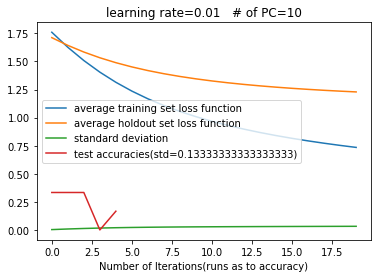

In [21]:
# Plot for 5 runs
total_loss = np.zeros((20,5))
std_loss = np.zeros((20,1))
avg_loss = np.zeros((20,1))
avg_ho_loss = np.zeros((20,1))
test_accur = np.zeros((5,1))
for i in range(5):
    # add up and average out the loss function for train and holdout in each run
    best_w,training_loss,holdout_loss,prediction,test_target= Twenty_Epoch_Train(0.01,10)
    total_loss[:,i]=training_loss[:,0]
    avg_loss+=training_loss
    avg_ho_loss+=holdout_loss
    
    #calculate test accuracy for each run
    num_cor_pred =0;
    for j in range(12):
        if (np.dot(prediction[j].T,test_target[j])!=0):
            num_cor_pred+=1
    test_accur[i]=num_cor_pred/12

std_accur = np.std(test_accur)

for n in range(20):
    std_loss[n]=np.std(total_loss[n,:])
avg_loss=0.2*avg_loss
avg_ho_loss=0.2*avg_ho_loss
plt.title('learning rate=0.01   # of PC=10')
plt.plot(avg_loss,label="average training set loss function")
plt.plot(avg_ho_loss,label="average holdout set loss function")
plt.plot(std_loss,label="standard deviation")
plt.plot(test_accur,label="test accuracies(std="+str(std_accur)+")")
plt.xlabel('Number of Iterations(runs as to accuracy)')
plt.legend(loc='best')
plt.savefig('3(a).png')

In [22]:
best_w,training_loss,holdout_loss,predic,test_target= Twenty_Epoch_Train(0.01,10)
pred_mat = ['']*12
exp_mat = ['']*12

for i in range(12):
    idx = 0
    idx1=0
    for j in range(6):
        if (predic[i][j]==1):
            idx = j
        if(test_target[i][j]==1):
            idx1 = j
    pred_mat[i]=(emotion_dictionary[idx])
    exp_mat[i]=(emotion_dictionary[idx1])
print(emotion_dictionary)
print(1/12*confusion_matrix(exp_mat,pred_mat))

['h', 'm', 's', 'f', 'a', 'd']
[[0.         0.08333333 0.         0.         0.08333333 0.        ]
 [0.         0.         0.         0.08333333 0.         0.08333333]
 [0.08333333 0.08333333 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.08333333 0.08333333]
 [0.         0.         0.08333333 0.         0.         0.08333333]
 [0.08333333 0.08333333 0.         0.         0.         0.        ]]


### 3(b) Batch Versus Stochastic Gradient Descent

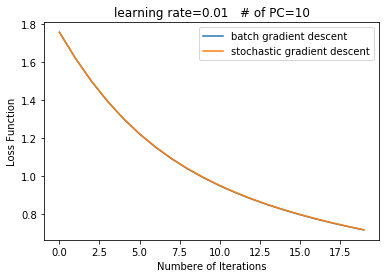

In [23]:
train_sub,test_sub,holdout_sub = split_subjects(subjects)
train = all_labels_of_subjects(train_sub)
holdout = all_labels_of_subjects(holdout_sub)
test = all_labels_of_subjects(test_sub)

# get image list of each set 
train_X = get_image_list(train)
test_X = get_image_list(test)
holdout_X = get_image_list(holdout)

# One hot encode corresponding targets, nx8 dimension
emotion_dictionary = ['h', 'm', 's', 'f', 'a', 'd']
e_t_train = one_hot_encoding(get_target_list(train),emotion_dictionary)
e_t_test = one_hot_encoding(get_target_list(test),emotion_dictionary)
e_t_holdout = one_hot_encoding(get_target_list(holdout),emotion_dictionary)

# Train loop for 20 epochs in both batch and stochastic
best_w,t_loss,h_loss= batch_g_d(train_X,e_t_train,holdout_X,e_t_holdout,0.01,10)
best_w_s,t_loss_s,h_loss_s= stoch_g_d(train_X,e_t_train,holdout_X,e_t_holdout,0.01,10)

plt.title('learning rate=0.01   # of PC=10')
plt.plot(t_loss,label='batch gradient descent')
plt.plot(t_loss_s,label='stochastic gradient descent')
plt.xlabel('Numbere of Iterations')
plt.ylabel('Loss Function')
plt.legend(loc='best')
plt.savefig('3(b).png')

### 3(c) Visualize the Weights

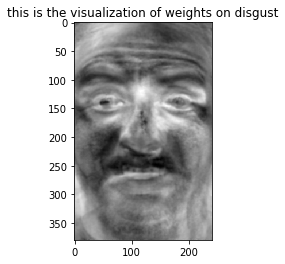

In [24]:
# Split all labels to train,test and holdout
train_sub,test_sub,holdout_sub = split_subjects(subjects)
train = all_labels_of_subjects(train_sub)
holdout = all_labels_of_subjects(holdout_sub)
test = all_labels_of_subjects(test_sub)

# get image list of each set 
train_X = get_image_list(train)
test_X = get_image_list(test)
holdout_X = get_image_list(holdout)

# One hot encode corresponding targets, nx8 dimension
emotion_dictionary = ['h', 'm', 's', 'f', 'a', 'd']
full_emo_dic = ["happy","maudlin","surprise","fear","anger","disgust"]
e_t_train = one_hot_encoding(get_target_list(train),emotion_dictionary)
e_t_test = one_hot_encoding(get_target_list(test),emotion_dictionary)
e_t_holdout = one_hot_encoding(get_target_list(holdout),emotion_dictionary)

# train the data with batch gradient descent model
best_w,t_loss,h_loss= batch_g_d(train_X,e_t_train,holdout_X,e_t_holdout,0.01,11)

def linear_sc(arr):
    max_ele = np.max(arr)
    return (255/max_ele)*arr

pca_v = PCA(k=11)
pca_v.fit(np.array(images[:]))
eigen_vec = pca_v.p_components.T

results = np.dot(best_w.T,eigen_vec)
results=linear_sc(results)
for i in range(6):
    plt.title("this is the visualization of weights on "+(full_emo_dic[i]))
    plt.imshow(results[i,:].reshape((images[0].shape[0],images[0].shape[1])), cmap='gray')
    plt.savefig('./visual_of_'+emotion_dictionary[i]+'_.png')